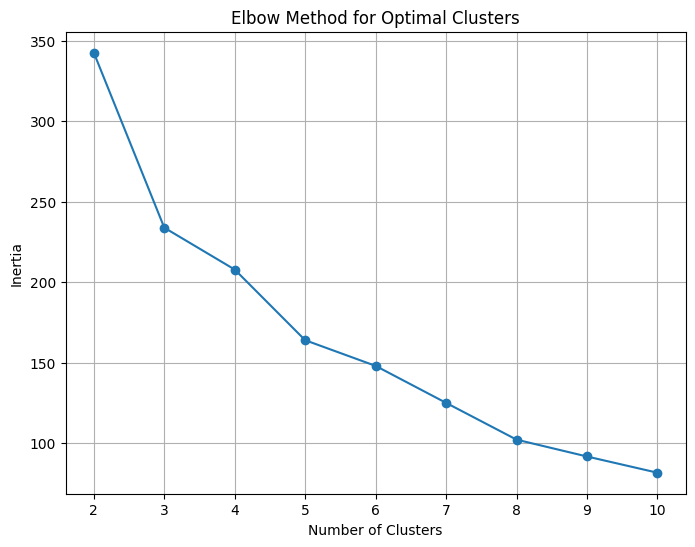

Davies-Bouldin Index: 1.12180191226693


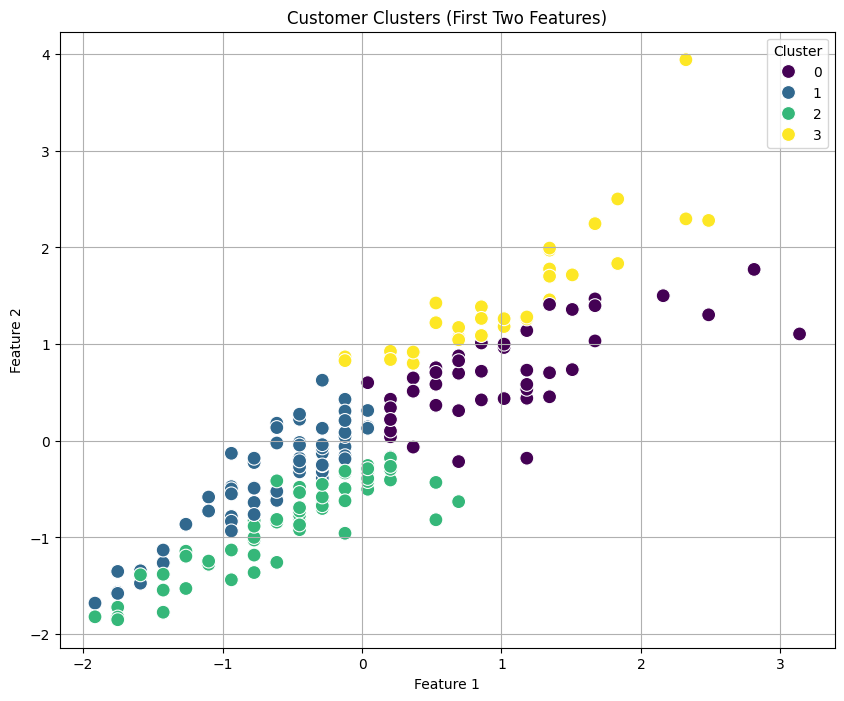

Clustering results saved to 'Customer_Clusters.csv'


In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Ensure consistent column names
customers.rename(columns={'Customer ID': 'CustomerID'}, inplace=True)
transactions.rename(columns={'Product ID': 'ProductID'}, inplace=True)

# Merge datasets for analysis
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

# Aggregating data for clustering
customer_profiles = merged_data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalValue': 'sum',
    'Price_y': 'mean',
}).reset_index()

# Rename 'Price_y' to 'Price' for clarity
customer_profiles.rename(columns={'Price_y': 'Price'}, inplace=True)

# Normalize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_profiles.drop(['CustomerID'], axis=1))

# Finding the optimal number of clusters using the Elbow Method
inertia = []
range_n_clusters = range(2, 11)
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Perform KMeans Clustering with optimal clusters (choose based on the Elbow Method)
optimal_clusters = 4  # Replace with the number identified from the elbow method
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(scaled_features)

# Add cluster labels to the customer profiles
grouped_customer_profiles = customer_profiles.copy()
grouped_customer_profiles['Cluster'] = kmeans.labels_

# Evaluate clustering performance
db_index = davies_bouldin_score(scaled_features, kmeans.labels_)
print(f"Davies-Bouldin Index: {db_index}")

# Visualize the clusters (using the first two principal components for simplicity)
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=scaled_features[:, 0],
    y=scaled_features[:, 1],
    hue=kmeans.labels_,
    palette='viridis',
    s=100
)
plt.title('Customer Clusters (First Two Features)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Save the clustering results
cluster_results = grouped_customer_profiles[['CustomerID', 'Cluster']]
cluster_results.to_csv('Customer_Clusters.csv', index=False)
print("Clustering results saved to 'Customer_Clusters.csv'")
